In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pathlib import Path

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

def bias(x, y): return np.mean(x - y)

def get_stats(x, y, nrmse = False):
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    if type(x) == list: x = np.array(x)
    if type(y) == list: y = np.array(y)
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)

    if nrmse:
        nrmse_value = rmse / np.mean(x)
        return r, b, mae, rmse, nrmse_value

    return r, b, mae, rmse
    
from spicy_snow.retrieval import retrieval_from_parameters

# import functions for downloading
from spicy_snow.download.sentinel1 import s1_img_search, hyp3_pipeline, download_hyp3, combine_s1_images
from spicy_snow.download.forest_cover import download_fcf
from spicy_snow.download.snow_cover import download_snow_cover

# import functions for pre-processing
from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images, s1_orbit_averaging,\
s1_clip_outliers, subset_s1_images, ims_water_mask, s1_incidence_angle_masking, merge_s1_subsets

# import the functions for snow_index calculation
from spicy_snow.processing.snow_index import calc_delta_VV, calc_delta_cross_ratio, \
    calc_delta_gamma, clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth

# import the functions for wet snow flag
from spicy_snow.processing.wet_snow import id_newly_frozen_snow, id_newly_wet_snow, \
    id_wet_negative_si, flag_wet_snow

# setup root logger
from spicy_snow.utils.spicy_logging import setup_logging

def s1_to_sd(ds, A = 1.5, B = 0.1, C = 0.6):
    # mask out outliers in incidence angle
    ds = s1_incidence_angle_masking(ds)
    
    # subset dataset by flight_dir and platform
    dict_ds = subset_s1_images(ds)

    for subset_name, subset_ds in dict_ds.items():
        # average each orbit to overall mean
        dict_ds[subset_name] = s1_orbit_averaging(subset_ds)
        # clip outlier values of backscatter to overall mean
        dict_ds[subset_name] = s1_clip_outliers(subset_ds)
    
    # recombine subsets
    ds = merge_s1_subsets(dict_ds)

    # calculate confidence interval
    # ds = add_confidence_angle(ds)

    ## Snow Index Steps
    # log.info("Calculating snow index")
    # calculate delta CR and delta VV
    ds = calc_delta_cross_ratio(ds, A = A)
    ds = calc_delta_VV(ds)

    # calculate delta gamma with delta CR and delta VV with FCF
    ds = calc_delta_gamma(ds, B = B)

    # clip outliers of delta gamma
    ds = clip_delta_gamma_outlier(ds)

    # calculate snow_index from delta_gamma
    ds = calc_snow_index(ds, ims_masking = True)

    # convert snow index to snow depth
    ds = calc_snow_index_to_snow_depth(ds, C = C)

    return ds

def optimize(r_ds, A, B, C, im_date):
    # holds rmse and r for optimizing rand dataset
    rand_rmse_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])
    rand_mae_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])
    rand_r_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])

    # optimize random dataset
    for a in A:
        for b in B:
            for c in C:
                r_ds_new = s1_to_sd(r_ds, A = a, B = b, C = c)
                r_sd_new = r_ds_new.where(r_ds_new['ims'] == 4)['snow_depth'].dropna(dim = 'time', how = 'all').sel(time = im_date, method = 'nearest')
                rand_r, rand_b, rand_mae, rand_rmse = get_stats(r_sd_new, r_ds_new['lidar-sd'], nrmse = False)
                rand_rmse_ds.loc[dict(A = a, B = b, C = C)] = rand_rmse
                rand_mae_ds.loc[dict(A = a, B = b, C = C)] = rand_mae
                rand_r_ds.loc[dict(A = a, B = b, C = C)] = rand_r
    
    return rand_rmse_ds, rand_mae_ds, rand_r_ds

In [9]:
data_dir = Path('~/Desktop/spicy-data/').expanduser()

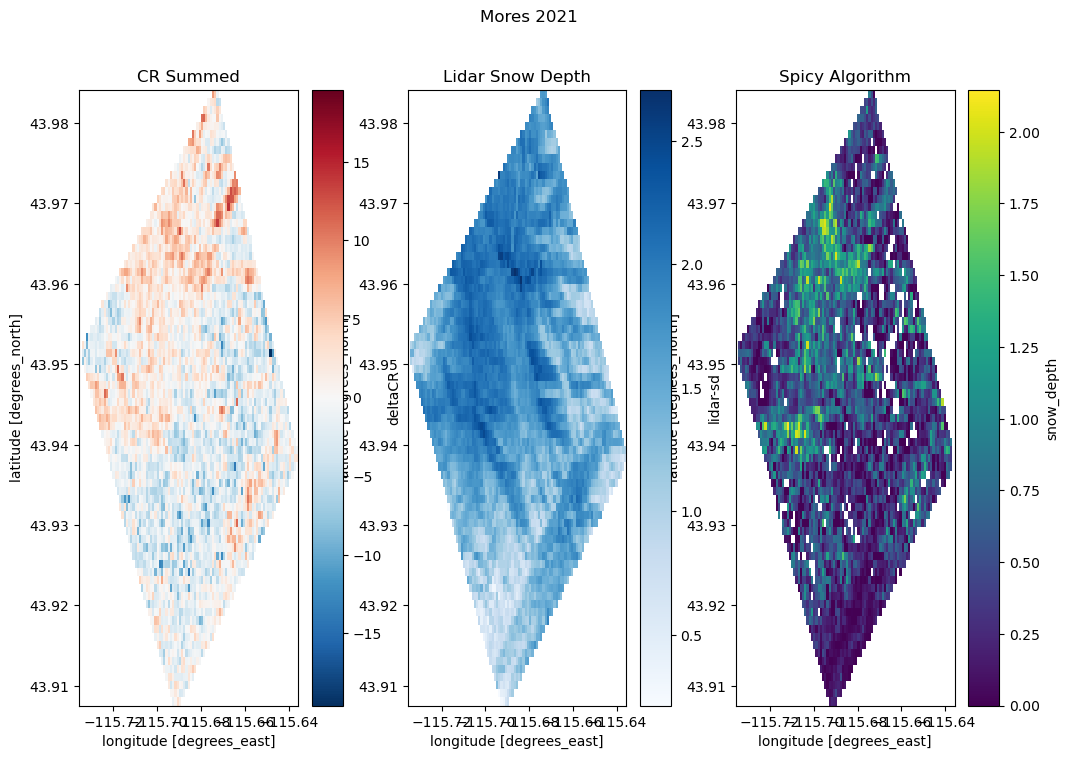

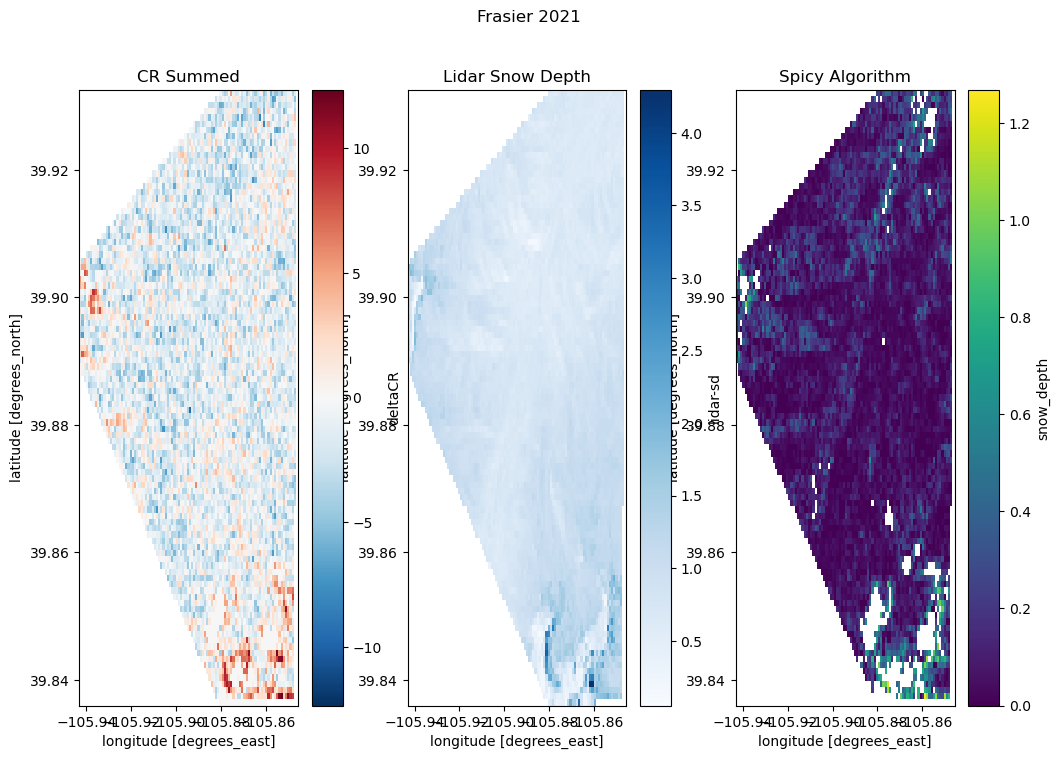

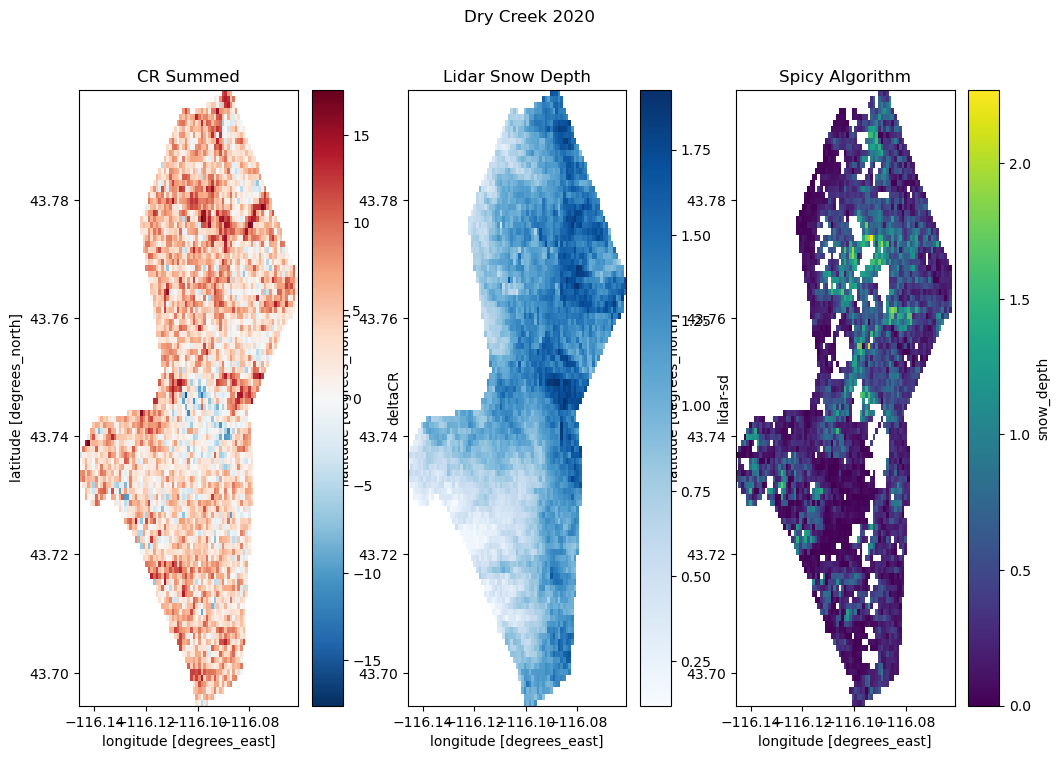

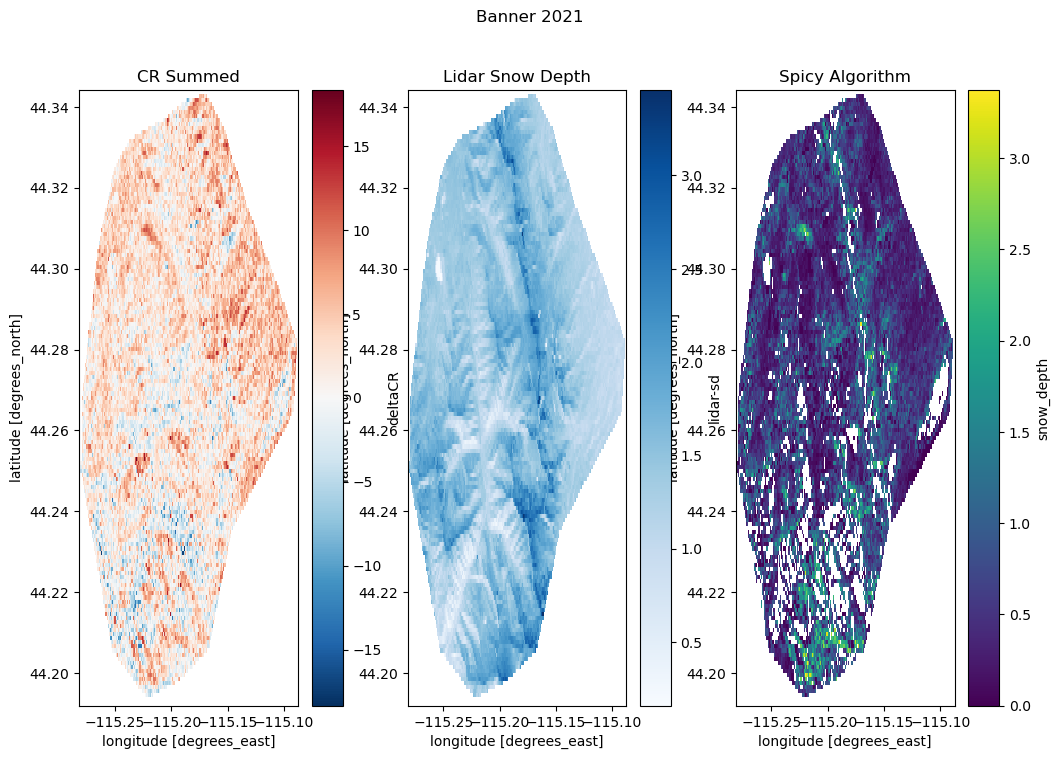

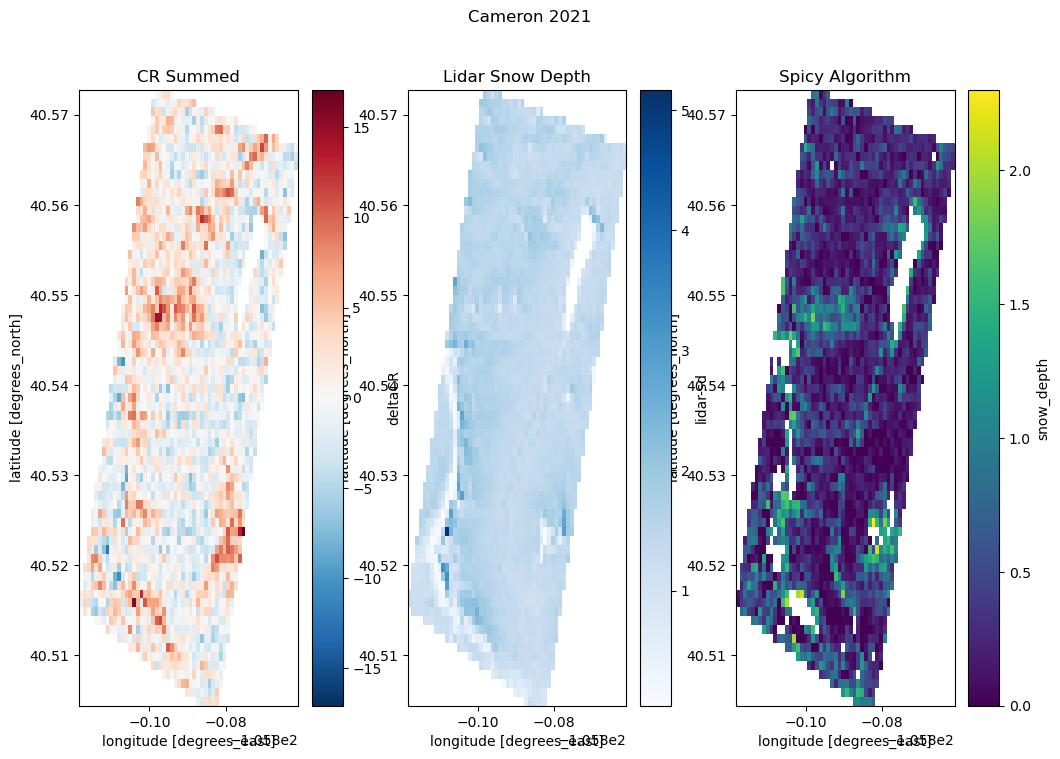

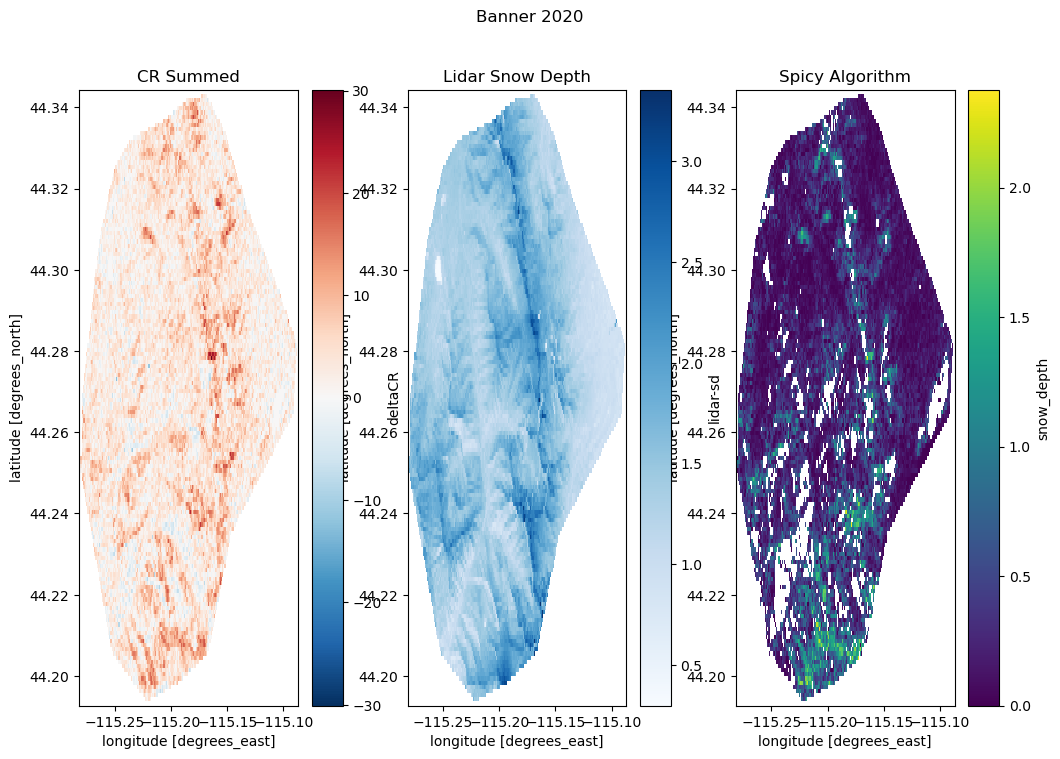

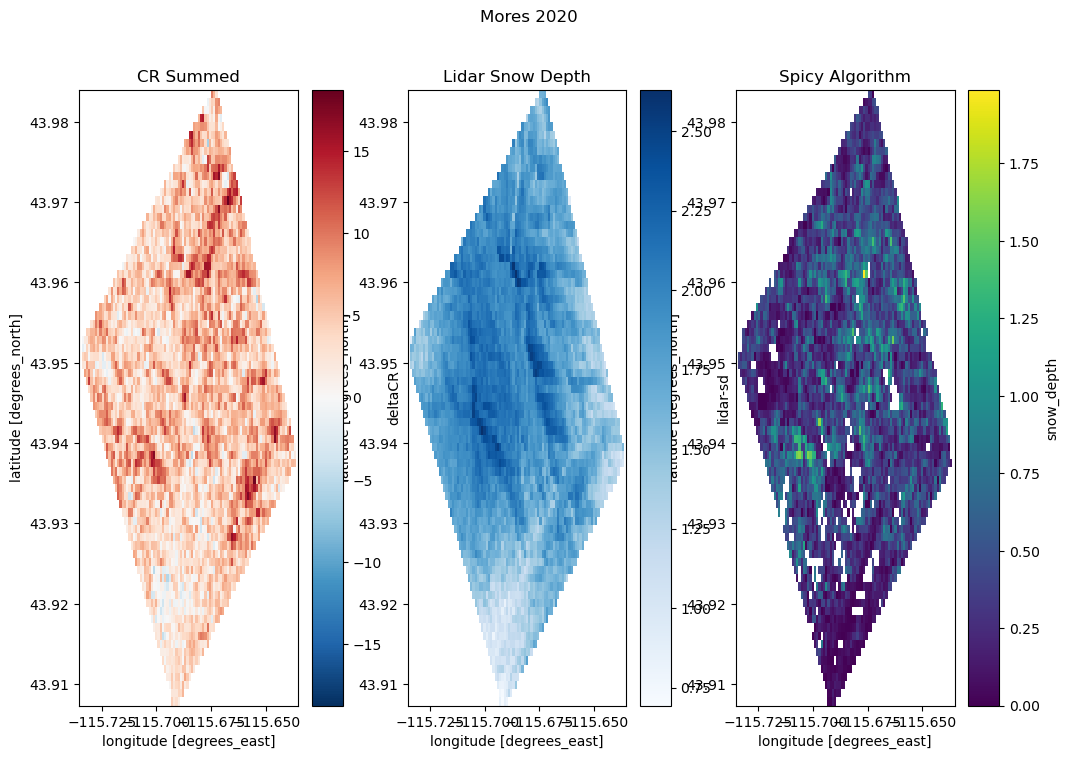

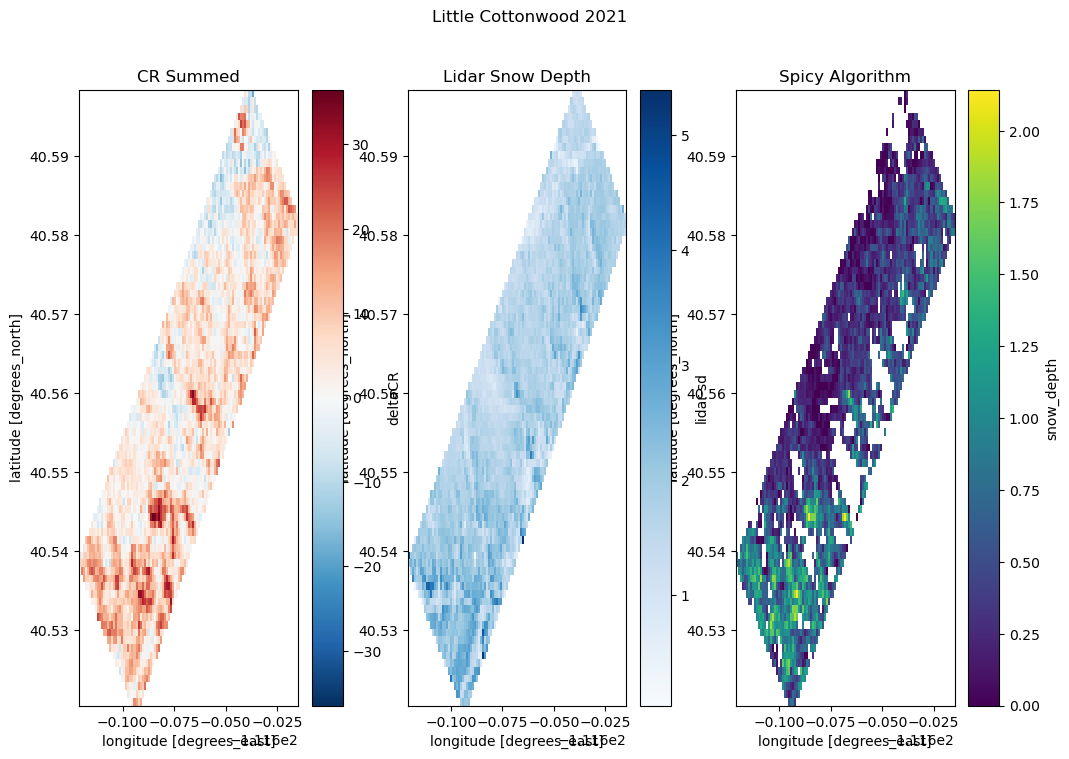

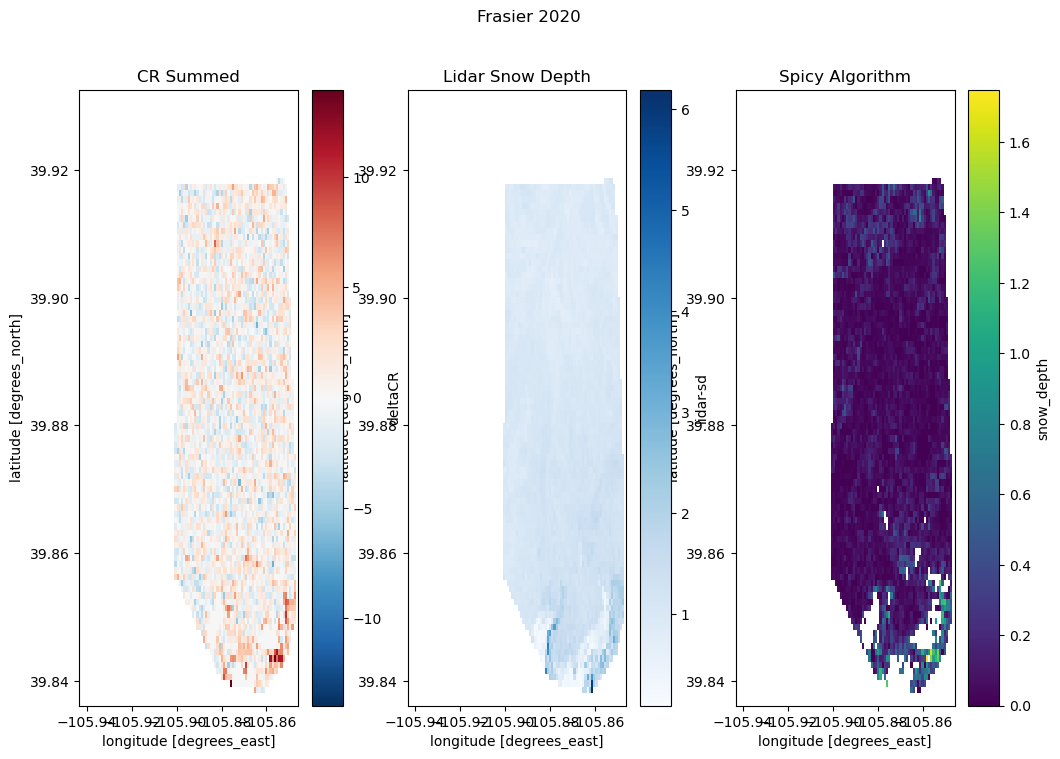

In [14]:
# Create parameter space
A = np.round(np.arange(1, 3.1, 1), 2)
B = np.round(np.arange(0, 2.01, 1), 2)
C = np.round(np.arange(0.25, 1.001, 0.25), 2)

df = pd.DataFrame()
for fp in data_dir.glob('*.nc'):
    stem = fp.stem
    ds = xr.open_dataset(fp)
    if stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
    start_t = f'{ds.time[0].dt.year.data.ravel()[0]}-12-01'
    ds = ds.load().sel(time = slice(start_t, None))
    fig, axes = plt.subplots(1, 3, figsize = (12, 8))
    ds.sum('time')['deltaCR'].where(~ds['lidar-sd'].isnull()).plot(ax =axes[0])
    ds['lidar-sd'].plot(cmap = 'Blues', ax =axes[1])
    r, b, mae, rmse = get_stats(ds.sum('time')['deltaCR'].where(~ds['lidar-sd'].isnull()), ds['lidar-sd'])
    df.loc[stem, 'correlation_CR'] = r

    rand_rmse_ds, rand_mae_ds, rand_r_ds = optimize(ds, A, B, C, im_date)

    a_best = rand_r_ds.max(['B', 'C']).idxmax('A')
    b_best = rand_r_ds.max(['C', 'A']).idxmax('B')
    c_best = rand_mae_ds.sel(A = a_best, B = b_best).idxmin('C')
    
    ds = s1_to_sd(ds, A = a_best, B = b_best, C = c_best)

    ds['snow_depth'].sel(time = im_date, method = 'nearest').where(~ds['lidar-sd'].isnull()).plot(ax = axes[2])

    axes[0].set_title('CR Summed')
    axes[1].set_title('Lidar Snow Depth')
    axes[2].set_title('Spicy Algorithm')
    fig.suptitle(stem.split('-')[0].replace('_',' '))

    r, b, mae, rmse = get_stats(ds['snow_depth'].sel(time = im_date, method = 'nearest').where(~ds['lidar-sd'].isnull()), ds['lidar-sd'])
    df.loc[stem, 'correlation_algorithm'] = r
    # ds['deltaCR'].plot()
    plt.show()

In [15]:
df

,correlation_CR,correlation_algorithm
Mores_2021-03-15,0.475948,0.402980
Frasier_2021-03-19,0.261113,0.216386
Dry_Creek_2020-02-19,0.036901,0.248898
Banner_2021-03-15,0.195464,0.409871
Cameron_2021-03-19,0.227562,-0.009784
Banner_2020-02-18,0.416271,0.433971
Mores_2020-02-09,0.220952,0.229354
Little_Cottonwood_2021-03-18,0.496015,0.525434
Frasier_2020-02-11,0.145886,0.351384


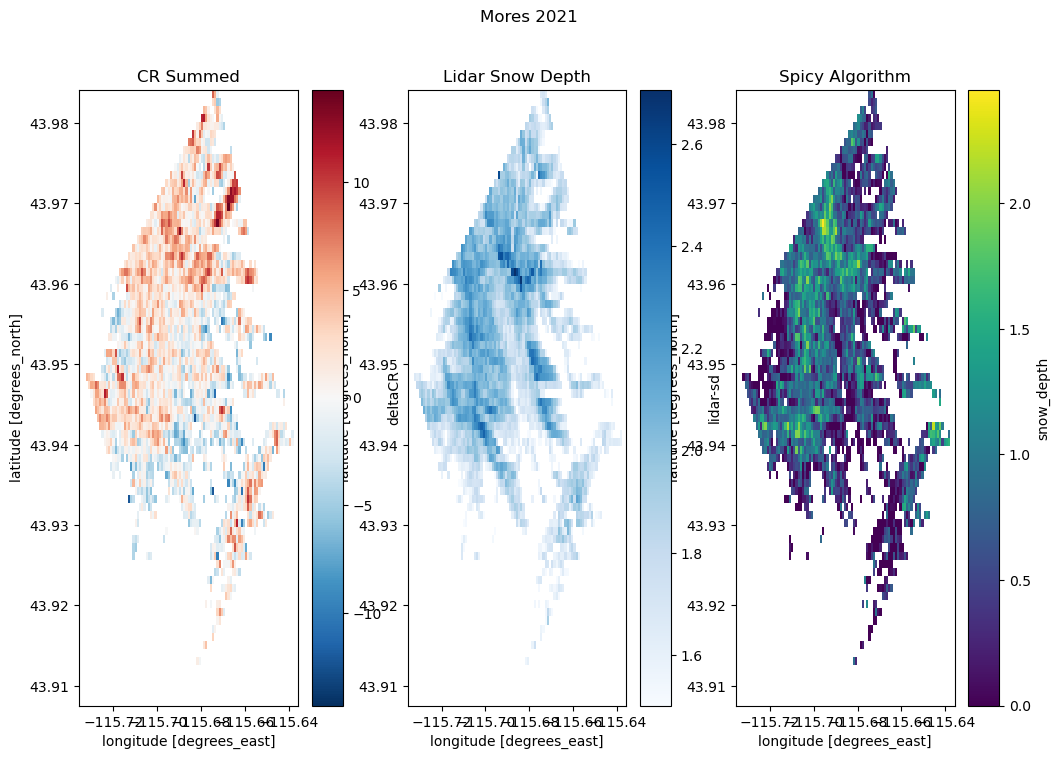

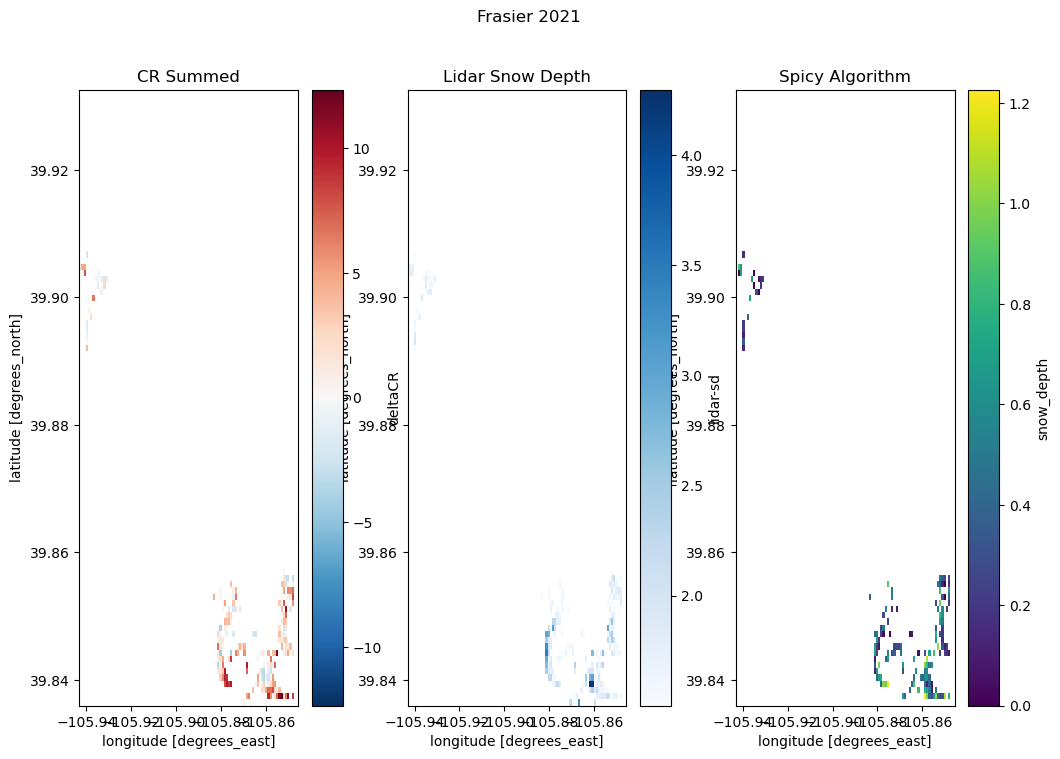

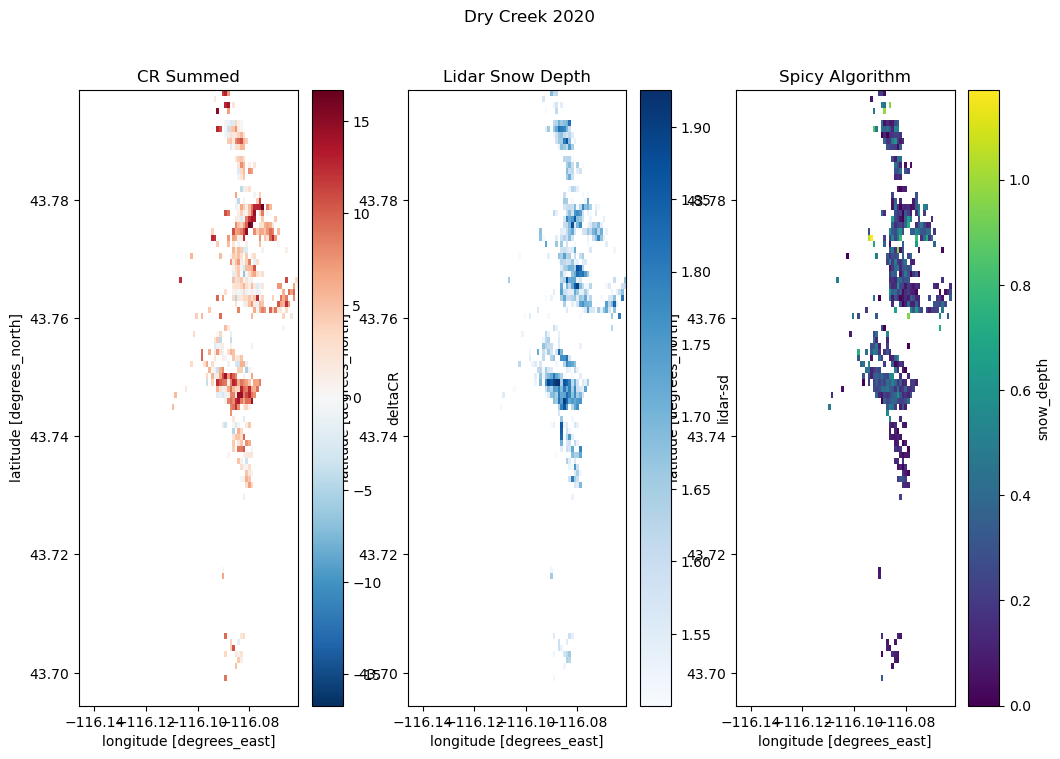

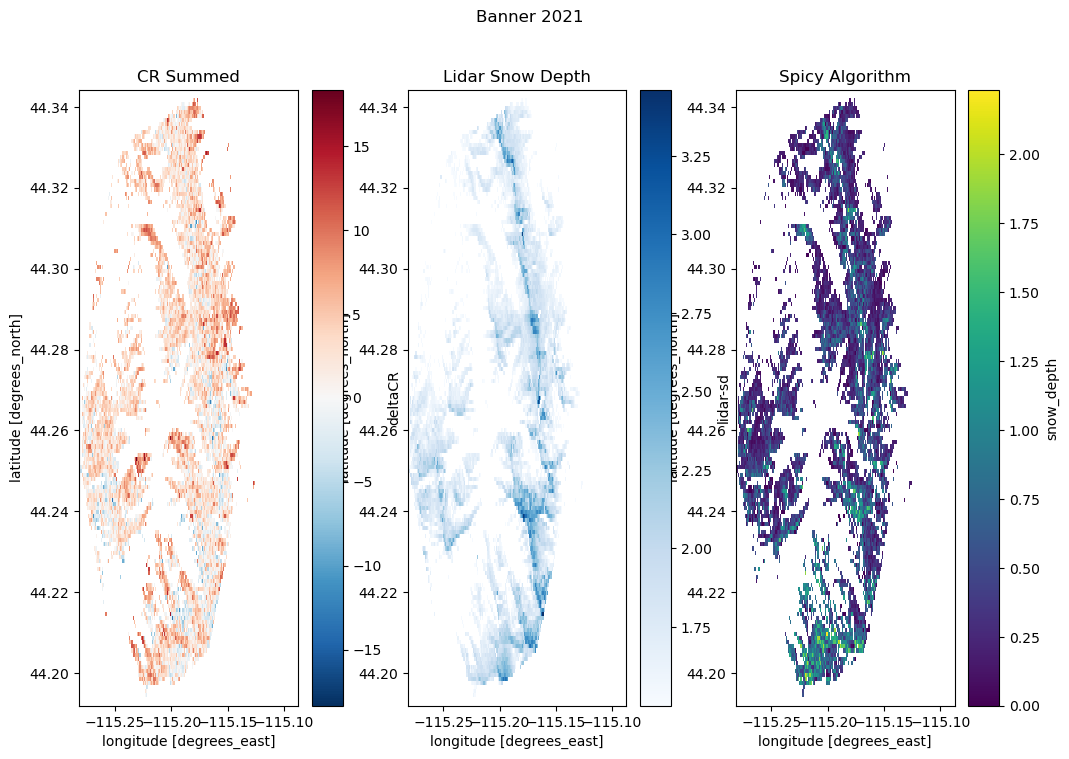

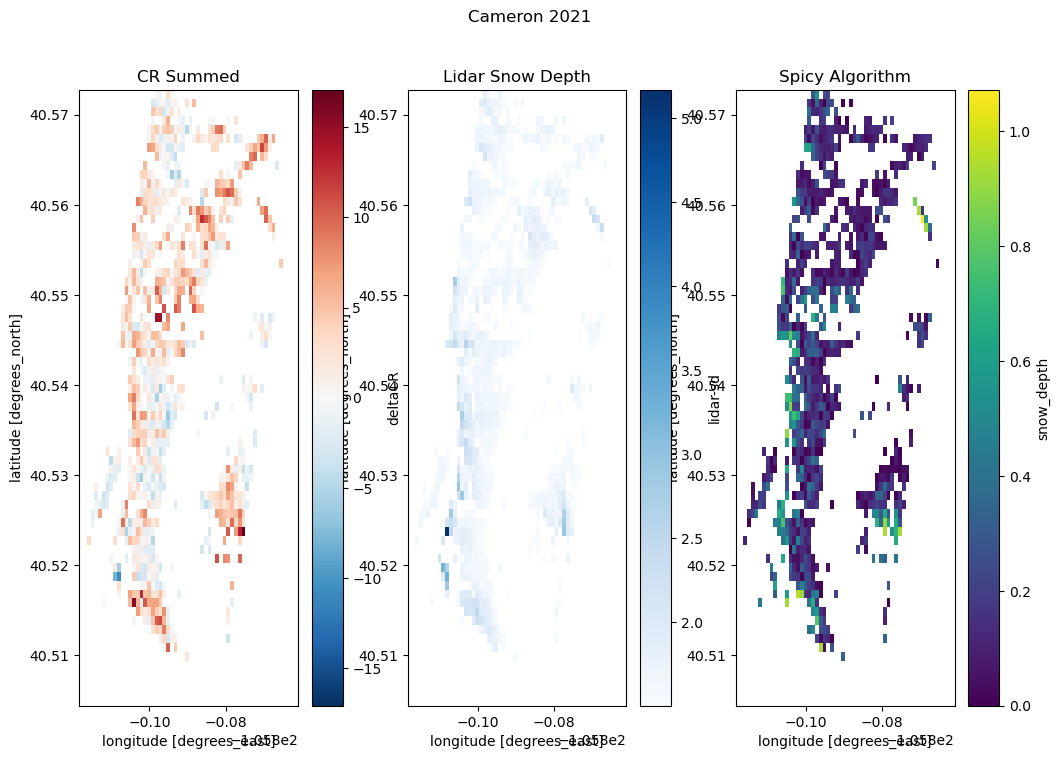

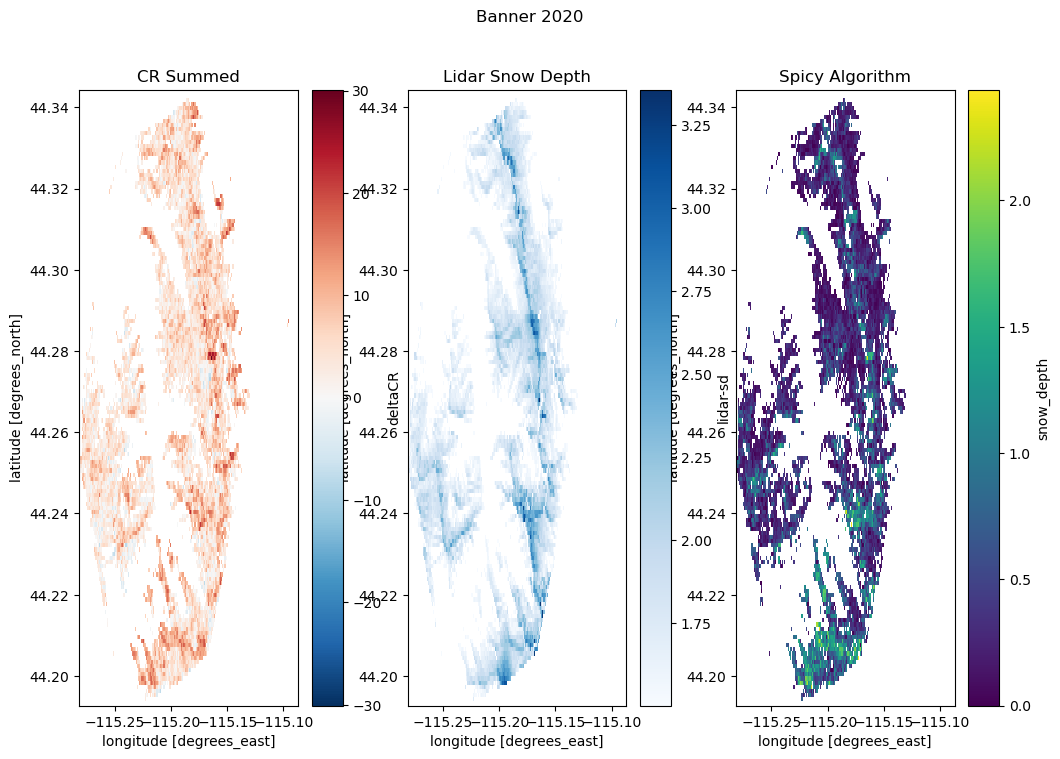

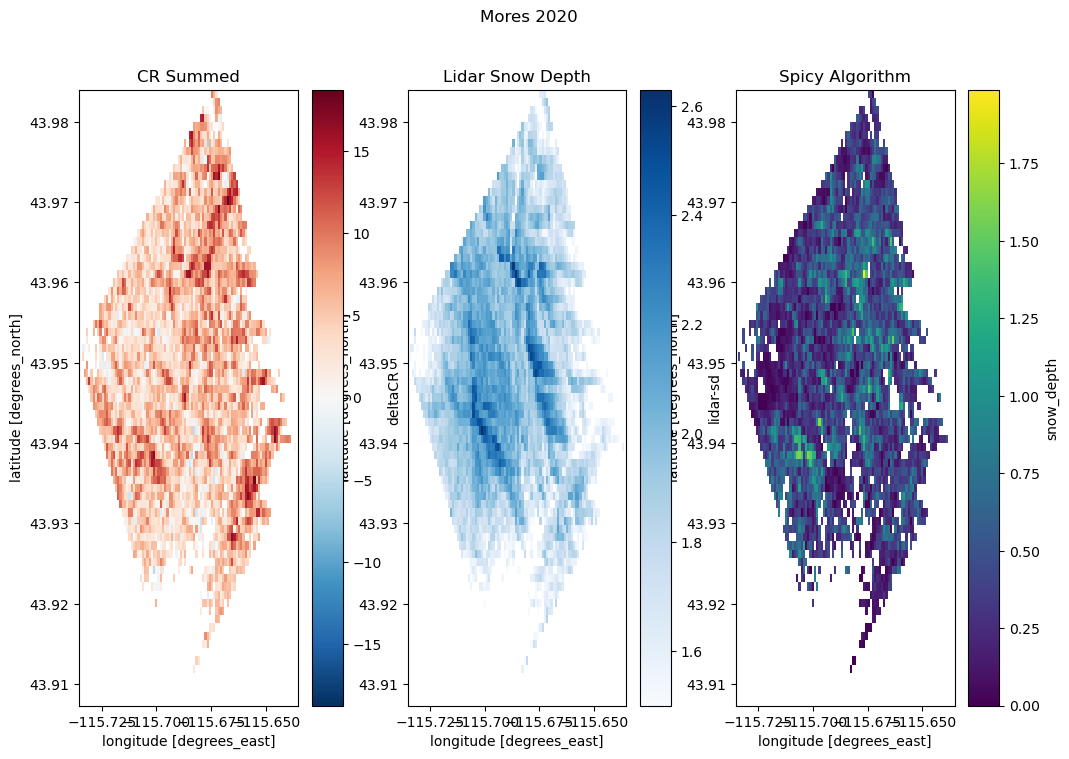

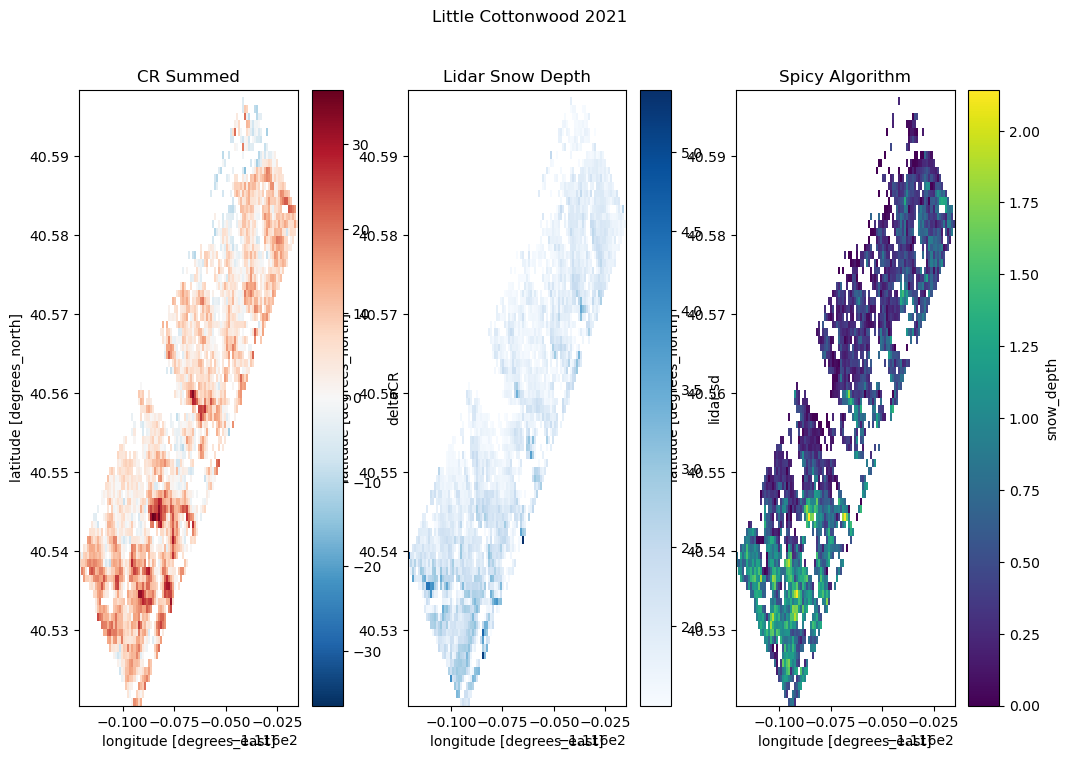

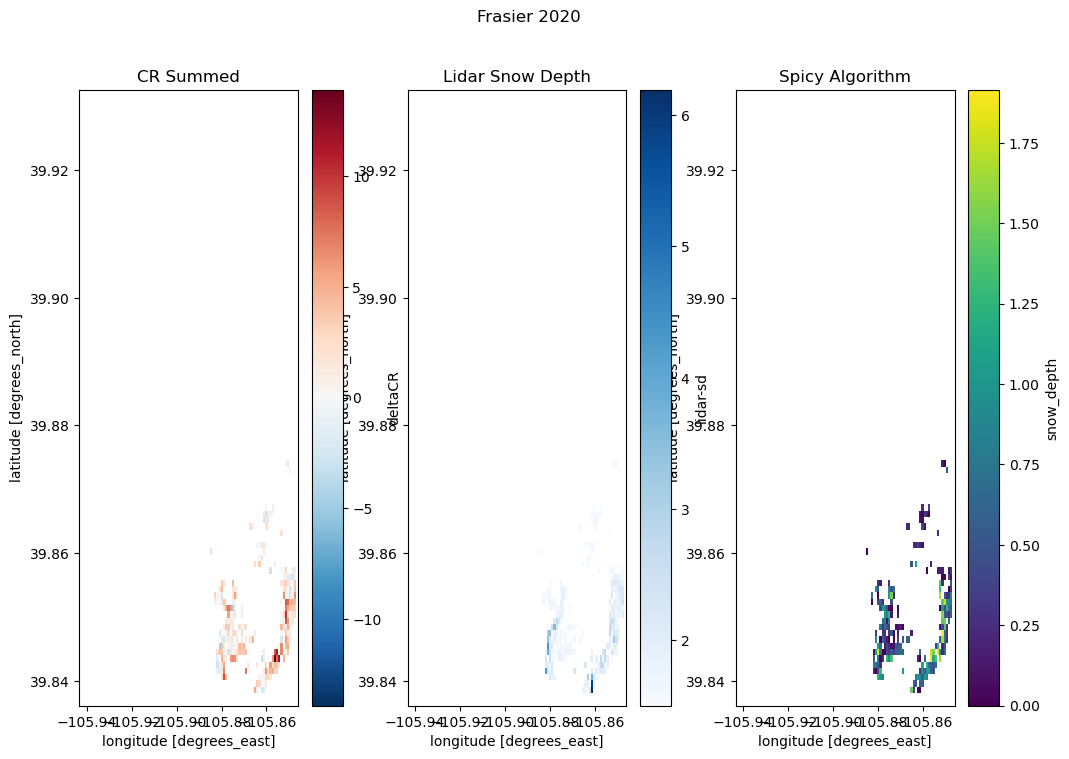

In [19]:
# Create parameter space
A = np.round(np.arange(1, 3.1, 1), 2)
B = np.round(np.arange(0, 2.01, 1), 2)
C = np.round(np.arange(0.25, 1.001, 0.25), 2)

df = pd.DataFrame()
for fp in data_dir.glob('*.nc'):
    stem = fp.stem
    ds = xr.open_dataset(fp)
    ds = ds.where(ds['lidar-sd'] > 1.5)
    if stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
    start_t = f'{ds.time[0].dt.year.data.ravel()[0]}-12-01'
    ds = ds.load().sel(time = slice(start_t, None))
    fig, axes = plt.subplots(1, 3, figsize = (12, 8))
    ds.sum('time')['deltaCR'].where(~ds['lidar-sd'].isnull()).plot(ax =axes[0])
    ds['lidar-sd'].plot(cmap = 'Blues', ax =axes[1])
    r, b, mae, rmse = get_stats(ds.sum('time')['deltaCR'].where(~ds['lidar-sd'].isnull()), ds['lidar-sd'])
    df.loc[stem, 'correlation_CR'] = r

    rand_rmse_ds, rand_mae_ds, rand_r_ds = optimize(ds, A, B, C, im_date)

    a_best = rand_r_ds.max(['B', 'C']).idxmax('A')
    b_best = rand_r_ds.max(['C', 'A']).idxmax('B')
    c_best = rand_mae_ds.sel(A = a_best, B = b_best).idxmin('C')
    
    ds = s1_to_sd(ds, A = a_best, B = b_best, C = c_best)

    ds['snow_depth'].sel(time = im_date, method = 'nearest').where(~ds['lidar-sd'].isnull()).plot(ax = axes[2])

    axes[0].set_title('CR Summed')
    axes[1].set_title('Lidar Snow Depth')
    axes[2].set_title('Spicy Algorithm')
    fig.suptitle(stem.split('-')[0].replace('_',' '))

    r, b, mae, rmse = get_stats(ds['snow_depth'].sel(time = im_date, method = 'nearest').where(~ds['lidar-sd'].isnull()), ds['lidar-sd'])
    df.loc[stem, 'correlation_algorithm'] = r
    # ds['deltaCR'].plot()
    plt.show()

In [20]:
df

,correlation_CR,correlation_algorithm
Mores_2021-03-15,0.428463,0.485507
Frasier_2021-03-19,-0.042891,0.137408
Dry_Creek_2020-02-19,0.177896,0.064904
Banner_2021-03-15,0.000803,0.392089
Cameron_2021-03-19,0.165246,0.407163
Banner_2020-02-18,0.233249,0.336680
Mores_2020-02-09,0.043073,0.085216
Little_Cottonwood_2021-03-18,0.390537,0.494970
Frasier_2020-02-11,-0.019111,0.163734


In [ ]:
for fp in data_dir.glob('*.nc'):
    ds = xr.open_dataset(fp)
    ds['deltaCR'].plot(col = 'time', col_wrap = 10)
    plt.show()

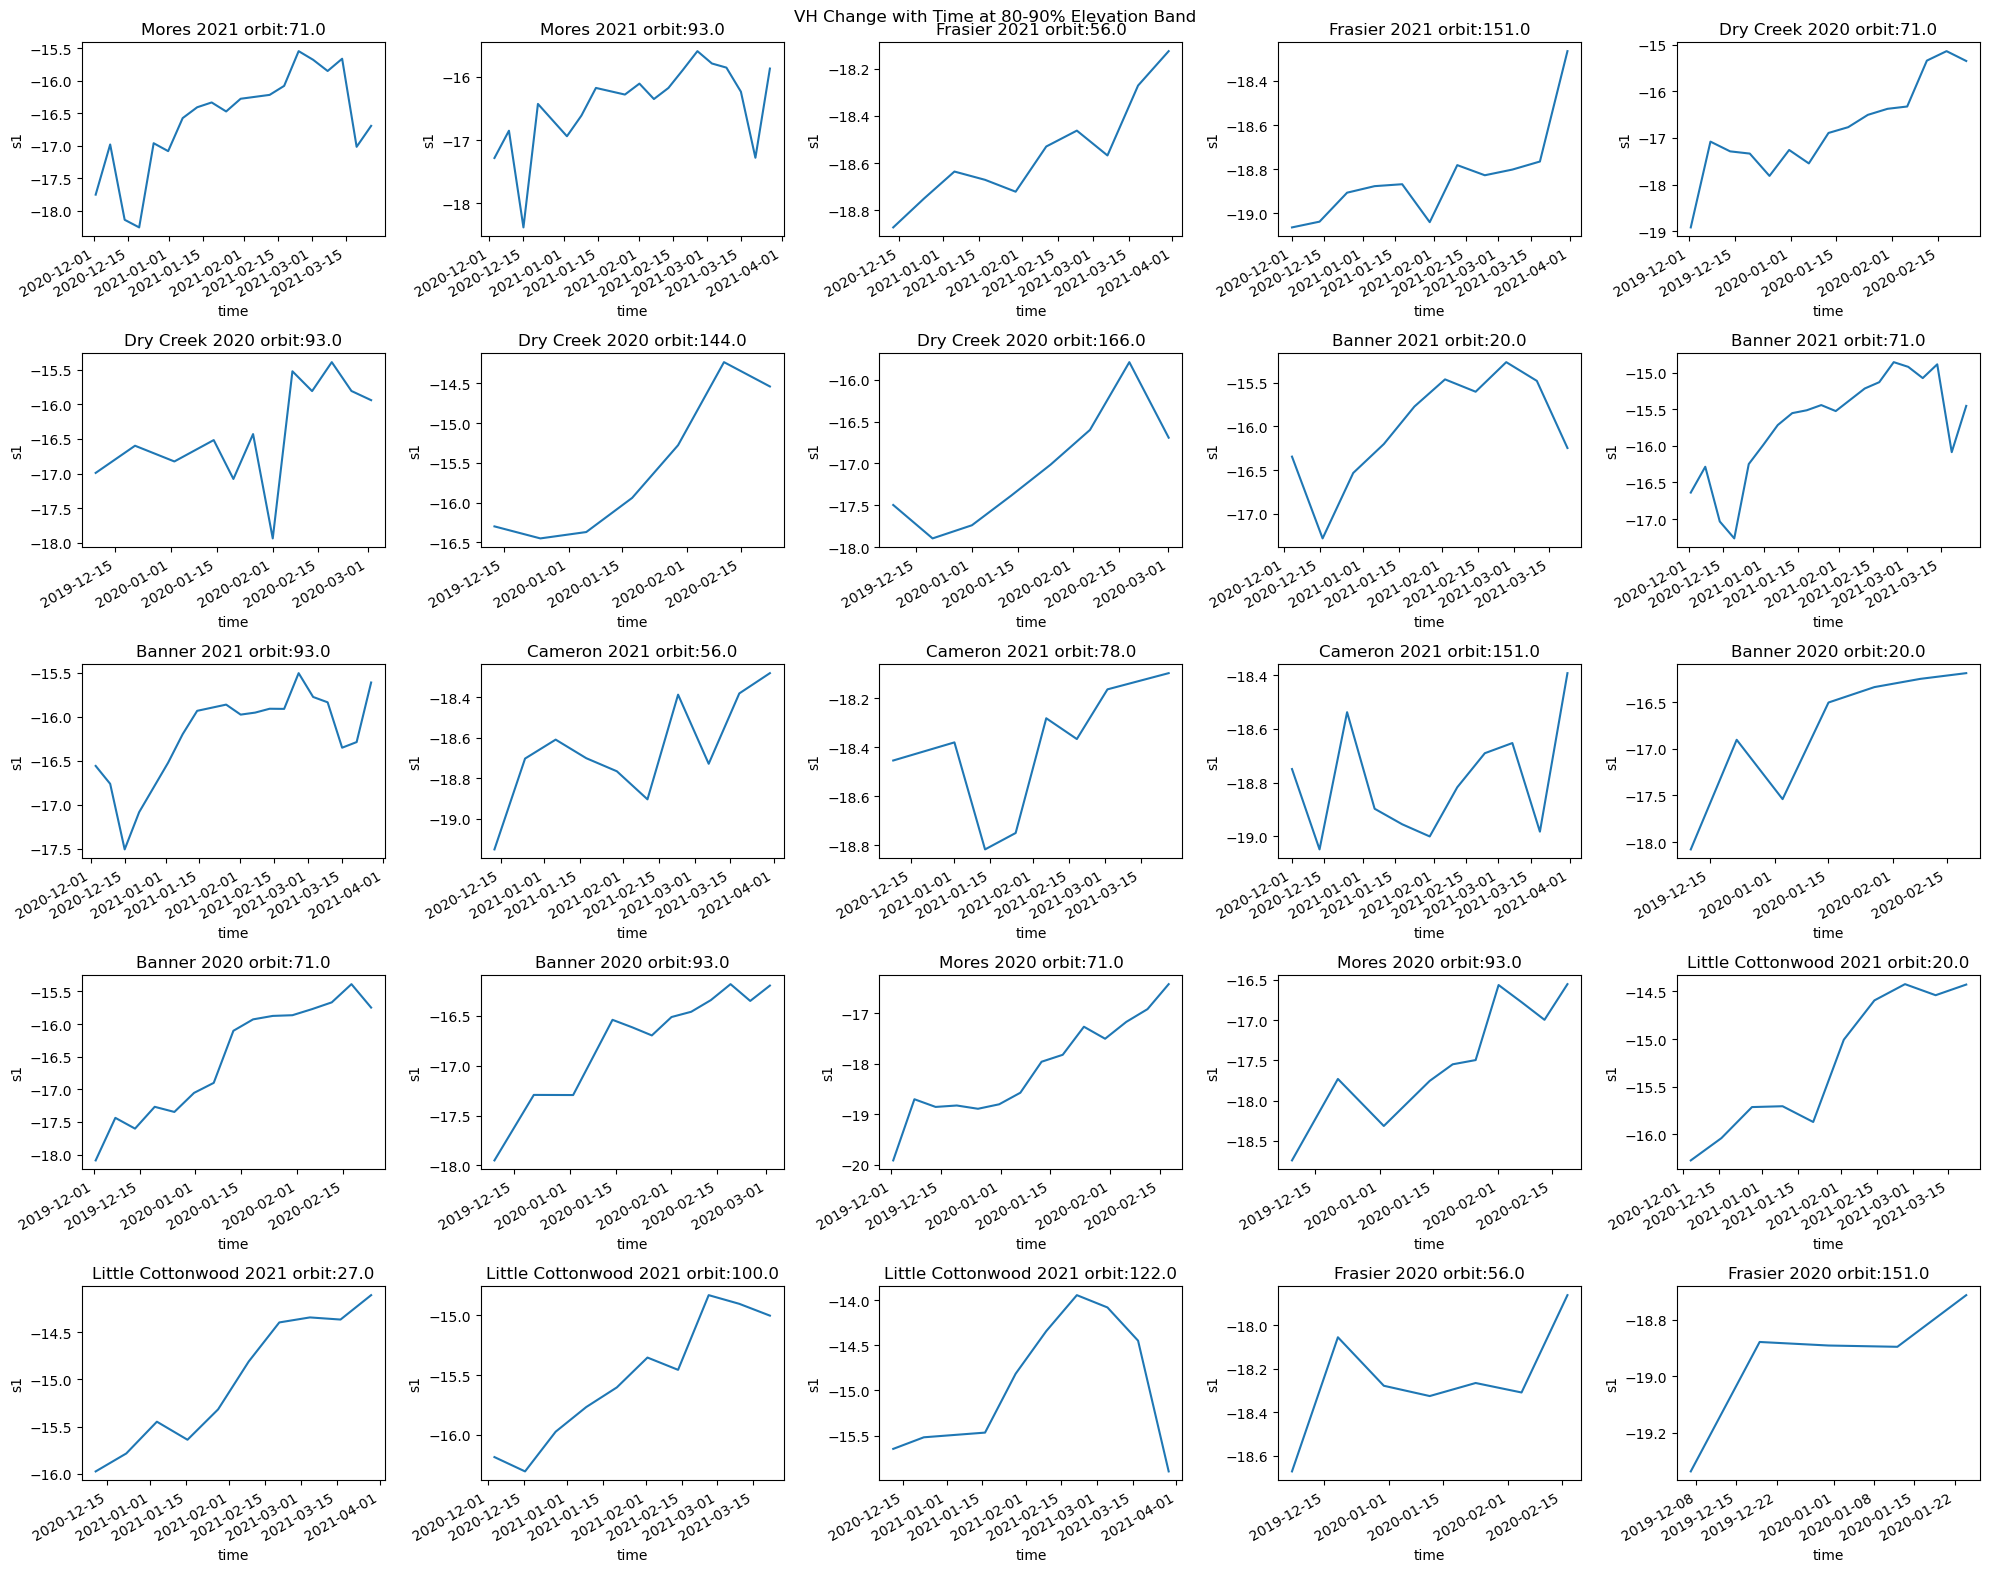

In [3]:
plots = 0
for fp in data_dir.glob('*.nc'):
    ds = xr.open_dataset(fp)
    for orbit, orbit_ds in ds.groupby('relative_orbit'):
        plots += 1

fig, axes = plt.subplots(5, 5, figsize = (20, 16))
i = 0
axes = axes.ravel()
for fp in data_dir.glob('*.nc'):
    ds = xr.open_dataset(fp)
    ds['CR'] = ds['s1'].sel(band = 'VH') - ds['s1'].sel(band = 'VV')
    start_t = f'{ds.time[0].dt.year.data.ravel()[0]}-12-01'
    ds = ds.load().sel(time = slice(start_t, None))
    for orbit, orbit_ds in ds.groupby('relative_orbit'):
        
        grouped = orbit_ds.groupby_bins('lidar-dem', 10) # .sel(time = ds.relative_orbit == 78)
        grouped = grouped.mean()['s1'].sel(band ='VH').sel({'lidar-dem_bins': list(grouped.groups.keys())[-2]})#.rolling(time = 2, min_periods = 1).mean()
        if (~grouped.isnull()).sum() != 0:
            grouped.plot(ax = axes[i])
            axes[i].set_title(f"{fp.stem.split('-')[0].replace('_', ' ')} orbit:{orbit}")
            i += 1

# for ax in axes[:-1]:
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     ax.set_xticklabels([])
#     ax.set_title('')
#     ax.set_yticks([])

# l_ax = axes[-1]
# l_ax.set_title('')

fig.suptitle("VH Change with Time at 80-90% Elevation Band")

plt.tight_layout()

In [38]:
np.unique(ds.relative_orbit.data)

array([ 56.,  78., 151.])

In [51]:
grouped = ds.load().sel(time = ds.relative_orbit == 56).sel(time = slice('2019-11-01')).groupby_bins('lidar-dem', 30) # .sel(time = ds.relative_orbit == 78)

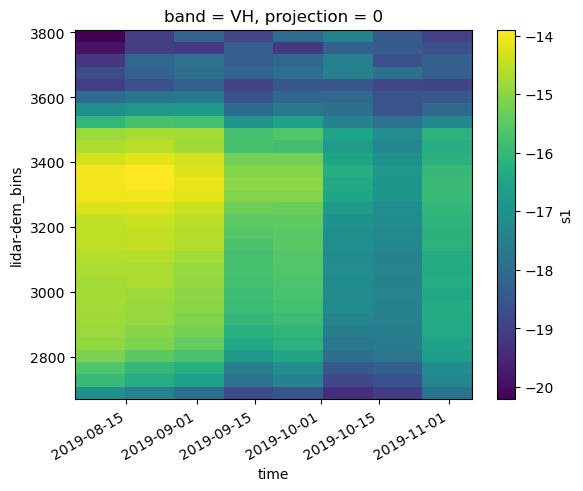

In [52]:
grouped.mean()['s1'].sel(band = 'VH').ffill('time').plot()